In [1]:
!pip3 install torch torchvision torchaudio

In [2]:
!pip install 'stable-baselines3[extra]' 'protobuf==3.20.*'

In [3]:
!pip install mss pydirectinput pytesseract

In [4]:
!pip install pyautogui

In [5]:
!pip install gymnasium

In [17]:
from mss import mss
import pyautogui
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
print("done")

done


In [18]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import cv2
import pyautogui
import time
from mss import mss
import pytesseract

class WebGame(gym.Env):
    def __init__(self):
        super(WebGame, self).__init__()
        self.observation_space = spaces.Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8)
        self.action_space = spaces.Discrete(3)

        self.cap = mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 500, 'left': 400, 'width': 660, 'height': 70}

    def step(self, action):
        # 0 - space, 1 - duck (down), 2 - noop
        actions_dict = {
            0: 'space',
            1: 'down',
            2: 'no_op'
        }
        if action != 2:
            pyautogui.press(actions_dict[action])

        done, done_cap = self.get_done_text()
        new_obs = self.get_observation()

        reward = 1
        info = {}
        terminated = done
        truncated = False  # Set this according to your environment's logic
        return new_obs, reward, terminated, truncated, info

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:, :, :3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    def reset(self, seed=None):
        self.seed(seed)
        time.sleep(1)
        pyautogui.click(x=500, y=500)
        pyautogui.press('space')
        return self.get_observation(), {}

    def close(self):
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.waitKey(1)

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        channel = np.reshape(resized, (1, 83, 100))
        return channel

    def get_done_text(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:, :, :3]
        done_strings = ["GAME", "GAHE", "GARA", "GARM", "GAWM"]

        done = False
        result = pytesseract.image_to_string(done_cap)[:4]
        if result in done_strings:
            done = True
        return done, done_cap



In [19]:
env = WebGame()

In [20]:
done, done_cap = env.get_done_text()
print(done)

True


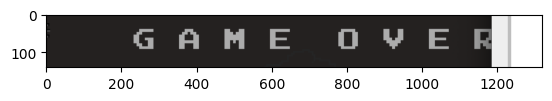

In [21]:
plt.imshow(done_cap)

In [22]:
pytesseract.image_to_string(done_cap)

'GAME OVE A\n'

In [7]:
for episode in range(10):
    observation = env.reset()
    done = False
    total_reward = 0

    while not done:
        observation, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f"Total Reward for Episode {episode} is {total_reward}")  

Total Reward for Episode 0 is 25
Total Reward for Episode 1 is 23
Total Reward for Episode 2 is 38
Total Reward for Episode 3 is 28
Total Reward for Episode 4 is 28
Total Reward for Episode 5 is 21
Total Reward for Episode 6 is 31
Total Reward for Episode 7 is 25
Total Reward for Episode 8 is 24
Total Reward for Episode 9 is 32


In [ ]:
# Create a callback for learning

In [23]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker


In [44]:
env_checker.check_env(env)

In [24]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_frequency, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_frequency = check_frequency
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_frequency == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True
        

In [25]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [26]:
callback = TrainAndLoggingCallback(check_frequency=1000, save_path=CHECKPOINT_DIR)

In [27]:
from stable_baselines3 import DQN

In [28]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, 
            buffer_size=200000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
# Training
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 17.8     |
|    ep_rew_mean      | 17.8     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 3        |
|    time_elapsed     | 20       |
|    total_timesteps  | 71       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.8     |
|    ep_rew_mean      | 20.8     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3        |
|    time_elapsed     | 46       |
|    total_timesteps  | 166      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.6     |
|    ep_rew_mean      | 22.6     |
|    exploration_rate | 0.974    |
| time/               |        

In [34]:
model = DQN.load(os.path.join('train', 'best_model_250000'))

In [35]:
for episode in range(1):
    observation, info = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(observation)
        obs, reward, done, truncated, info = env.step(int(action))
        total_reward += reward
    print(f"Total Reward for Episode {episode} is {total_reward}")


Total Reward for Episode 0 is 61
